## EDA Log Moodel

### Overall data

In [2]:
import pandas as pd
import json
from datetime import datetime

def eda_moodle_logs(file_path):
    # 1. Đọc file CSV hoặc Excel
    df = pd.read_csv(file_path) if file_path.endswith(".csv") else pd.read_excel(file_path)

    print("📊 Kích thước dữ liệu:", df.shape)
    print("\n📌 Các cột:")
    print(df.columns.tolist())

    print("\n🧑‍🎓 Số lượng user duy nhất:", df["userid"].nunique())
    print("📚 Số lượng khóa học (courseid):", df["courseid"].nunique())

    print("\n📆 Thời gian hoạt động:")
    df["datetime"] = pd.to_datetime(df["timecreated"], unit='s')
    print("   └ Ngày đầu:", df["datetime"].min())
    print("   └ Ngày cuối:", df["datetime"].max())

    print("\n⚙️ Top 10 loại event phổ biến:")
    print(df["eventname"].value_counts().head(10))

    print("\n🎯 Top 10 hành động:")
    print(df["action"].value_counts().head(10))

    print("\n🎯 Top 10 target:")
    print(df["target"].value_counts().head(10))

    # 2. Thống kê theo người dùng
    print("\n📈 Hành vi theo user (số dòng mỗi user):")
    print(df["userid"].value_counts().head(5))

    # 3. Thử phân tích cột 'other'
    print("\n🔍 Xem thử cột 'other':")
    sample_other = df["other"].dropna().sample(3, random_state=42)
    for idx, val in enumerate(sample_other):
        try:
            parsed = json.loads(val)
            print(f"   ➤ Mẫu {idx+1}: {parsed}")
        except:
            print(f"   ➤ Mẫu {idx+1}: Không phải JSON")

    print("\n✅ EDA hoàn tất.")

In [3]:
eda_moodle_logs("data/udk_moodle_log.csv")

📊 Kích thước dữ liệu: (1259411, 8)

📌 Các cột:
['id', 'timecreated', 'eventname', 'action', 'target', 'userid', 'courseid', 'other']

🧑‍🎓 Số lượng user duy nhất: 1110
📚 Số lượng khóa học (courseid): 897

📆 Thời gian hoạt động:
   └ Ngày đầu: 2022-09-01 06:22:13
   └ Ngày cuối: 2023-01-25 00:15:43

⚙️ Top 10 loại event phổ biến:
eventname
\core\event\webservice_function_called          288851
\core\event\course_viewed                       279917
\mod_assign\event\course_module_viewed           94557
\core\event\dashboard_viewed                     80736
\mod_resource\event\course_module_viewed         74133
\mod_assign\event\submission_status_viewed       70439
\core\event\user_loggedin                        66271
\mod_quiz\event\attempt_viewed                   30620
\core\event\course_module_completion_updated     26857
\gradereport_user\event\grade_report_viewed      18850
Name: count, dtype: int64

🎯 Top 10 hành động:
action
viewed       770749
called       288851
loggedin      66

### Hàm EDA cho một userid cụ thể

In [28]:
def eda_user_logs(df, userid):
    # 1. Lọc dữ liệu theo userid
    user_df = df[df['userid'] == userid].copy()

    if user_df.empty:
        print(f"❌ Không tìm thấy dữ liệu cho userid = {userid}")
        return

    print(f"\n📍 EDA cho userid = {userid}")
    print("🔢 Số lượng log:", len(user_df))

    # 2. Chuyển đổi thời gian
    user_df["datetime"] = pd.to_datetime(user_df["timecreated"], unit='s')
    print("📆 Khoảng thời gian hoạt động:")
    print("   └ Từ:", user_df["datetime"].min())
    print("   └ Đến:", user_df["datetime"].max())

    # 3. Thống kê loại event
    print("\n⚙️ Các event phổ biến:")
    print(user_df["eventname"].value_counts().head(10))

    # 4. Hành động và mục tiêu
    print("\n🎯 Hành động:")
    print(user_df["action"].value_counts())

    print("\n🎯 Target:")
    print(user_df["target"].value_counts())

    # 5. Phân tích theo ngày (optional)
    daily = user_df.groupby(user_df["datetime"].dt.date).size()
    print("\n📈 Log mỗi ngày (top 5):")
    print(daily.sort_values(ascending=False).head())

    # 6. Xem thử các dòng log cụ thể
    print("\n🔍 Một vài dòng log mẫu:")
    print(user_df.head(3)[["datetime", "eventname", "action", "target"]])

In [29]:
df_logs = pd.read_csv("data/udk_moodle_log.csv")  # hoặc logs_full.csv

eda_user_logs(df_logs, userid=8602)


📍 EDA cho userid = 8602
🔢 Số lượng log: 2703
📆 Khoảng thời gian hoạt động:
   └ Từ: 2022-09-01 18:16:55
   └ Đến: 2023-01-24 18:14:49

⚙️ Các event phổ biến:
eventname
\core\event\webservice_function_called          1395
\core\event\course_viewed                        618
\gradereport_user\event\grade_report_viewed      145
\mod_resource\event\course_module_viewed         127
\core\event\dashboard_viewed                      96
\core\event\user_loggedin                         75
\core\event\course_module_completion_updated      57
\mod_forum\event\course_module_viewed             34
\mod_quiz\event\attempt_viewed                    29
\mod_forum\event\discussion_viewed                28
Name: count, dtype: int64

🎯 Hành động:
action
called        1395
viewed        1150
loggedin        75
updated         57
loggedout        9
created          5
uploaded         3
downloaded       2
sent             2
submitted        2
failed           1
started          1
reviewed         1
Name: c

### Phân loại người dùng dựa trên hành vi

#### Bước 1: Tạo đặc trưng cho hành vi

In [8]:
import pandas as pd

# Đọc dữ liệu
df = pd.read_csv("data/udk_moodle_log.csv")  # thay bằng đường dẫn thật

# Đếm số lần mỗi action theo user
user_action_counts = df.groupby(["userid", "action"]).size().unstack(fill_value=0)

# Tính tổng số hành động mỗi user
user_action_counts["total"] = user_action_counts.sum(axis=1)

# Tính tỷ lệ các hành động
for action in ["viewed", "called", "submitted", "uploaded", "graded", "created", "reviewed"]:
    if action in user_action_counts.columns:
        user_action_counts[f"pct_{action}"] = user_action_counts[action] / user_action_counts["total"]
    else:
        user_action_counts[f"pct_{action}"] = 0.0

#### Bước 2: Rule-based classification (đơn giản nhưng hiệu quả)

In [ ]:
# Phân loại người dùng dựa trên hành vi
def classify_user(row):
    if row["pct_called"] > 0.6:  # trước là 0.8
        return "system"
    if row["graded"] > 5 or row["created"] > 5 or row["reviewed"] > 5:
        return "teacher"
    return "student"

user_action_counts["role"] = user_action_counts.apply(classify_user, axis=1)


In [16]:
# Đếm số lượng mỗi loại role
print(user_action_counts["role"].value_counts())
print(user_action_counts[user_action_counts["role"] == "teacher"].sort_values("graded", ascending=False).head(10))

student_ids = user_action_counts[user_action_counts["role"] == "student"].index

df_clean = df[df["userid"].isin(student_ids)].copy()

# Xuất ra file CSV nếu cần
# user_action_counts.to_csv("user_roles.csv")

role
teacher    728
student    309
system      73
Name: count, dtype: int64
action  abandoned  accepted  added  assessed  assigned  called  closed  \
userid                                                                   
3               0         0     10         0         0       0       3   
203             0         0      0         0        35       0       0   
3631            0         0      0         0         0       0       7   
4               0         0      0         0         0     632       8   
231             0         0      0         0         0       0       0   
6339            0         0      0         0         0       0       2   
7187            0         0      1        26         0       0       9   
8044            0         0      0         0         0       0       0   
702             0         0      0         0         0       0      10   
8502            0         0      0         0         0       0       0   

action  created  deleted  downloade

### Đặc trưng trên 1 course

In [17]:
def extract_learning_behavior(df):
    df["datetime"] = pd.to_datetime(df["timecreated"], unit="s")

    def is_video_event(row):
        return "mod_resource" in row or "mod_url" in row

    def is_quiz_event(row):
        return "mod_quiz" in row or "attempt_viewed" in row

    def is_assignment_event(row):
        return "mod_assign" in row or "submitted" in row or "submission_status" in row

    def is_grade_view(row):
        return "grade_report" in row

    behaviors = []

    for (user, course), group in df.groupby(["userid", "courseid"]):
        group_eventnames = group["eventname"].fillna("").astype(str) + group["target"].fillna("").astype(str)

        behaviors.append({
            "userid": user,
            "courseid": course,
            "num_video_views": sum(group_eventnames.apply(is_video_event)),
            "num_quiz_attempts": sum(group_eventnames.apply(is_quiz_event)),
            "num_assignments_submitted": sum(group_eventnames.apply(is_assignment_event)),
            "num_grade_views": sum(group_eventnames.apply(is_grade_view)),
            "num_total_events": len(group),
            "first_time": group["datetime"].min(),
            "last_time": group["datetime"].max(),
        })

    df_behavior = pd.DataFrame(behaviors)
    df_behavior["duration_days"] = (df_behavior["last_time"] - df_behavior["first_time"]).dt.days + 1

    return df_behavior

In [19]:
df_behavior = extract_learning_behavior(df_clean)

# Lưu ra CSV
df_behavior.to_csv("student_learning_behavior.csv", index=False)

print("✅ Đã lưu file: student_learning_behavior.csv")
print(df_behavior.head())

✅ Đã lưu file: student_learning_behavior.csv
   userid  courseid  num_video_views  num_quiz_attempts  \
0    6968         0                0                  0   
1    6968         1                0                  0   
2    7101         0                0                  0   
3    7101         1                0                  0   
4    7101      1502                0                  0   

   num_assignments_submitted  num_grade_views  num_total_events  \
0                          0                0                 5   
1                          0                1                 1   
2                          0                0                55   
3                          0               14                14   
4                          0                0                 1   

           first_time           last_time  duration_days  
0 2022-09-08 20:39:10 2022-09-08 20:40:08              1  
1 2022-09-08 20:39:39 2022-09-08 20:39:39              1  
2 2022-11-07 09:58:3

### Code lọc & phân tích hành vi học tập đáng chú ý:

In [20]:
# Ngưỡng lọc để chọn user-course có hành vi học tập rõ ràng
def filter_deep_learning_cases(df_behavior):
    filtered = df_behavior[
        (df_behavior["num_total_events"] >= 30) & (
            (df_behavior["num_quiz_attempts"] >= 10) |
            (df_behavior["num_assignments_submitted"] >= 1)
        ) & (df_behavior["duration_days"] >= 10)
    ]
    return filtered.sort_values(["userid", "courseid"])

# Áp dụng lọc
df_deep = filter_deep_learning_cases(df_behavior)

# In kết quả
print(f"✅ Số lượng user-course nên phân tích sâu: {len(df_deep)}")
print("🔍 Một vài trường hợp tiêu biểu:")
print(df_deep.head(10))

# Lưu kết quả
df_deep.to_csv("user_course_to_analyze.csv", index=False)
print("📁 Đã lưu ra file: user_course_to_analyze.csv")

✅ Số lượng user-course nên phân tích sâu: 341
🔍 Một vài trường hợp tiêu biểu:
    userid  courseid  num_video_views  num_quiz_attempts  \
7     7101      2188                0                 76   
8     7101      2192                0                  0   
22    7162       816                4                  0   
28    7162      3094               10                  0   
35    7191      1827                0                  0   
41    7192       816                7                  0   
44    7192      2358                9                  0   
54    7246      3094               17                  0   
56    7267        42               11                  2   
57    7267       591               15                  0   

    num_assignments_submitted  num_grade_views  num_total_events  \
7                           2                0                83   
8                          22                0                34   
22                         12                0           

### Code: Phân tích hành vi học tập qua biểu đồ

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/2752115879.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


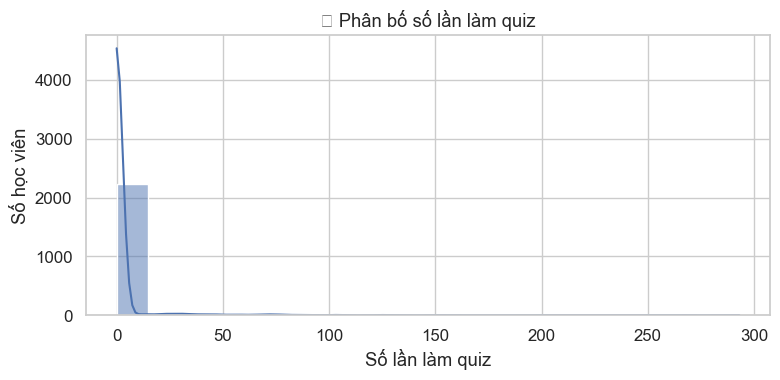

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/2752115879.py:29: UserWarning: Glyph 127909 (\N{MOVIE CAMERA}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127909 (\N{MOVIE CAMERA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


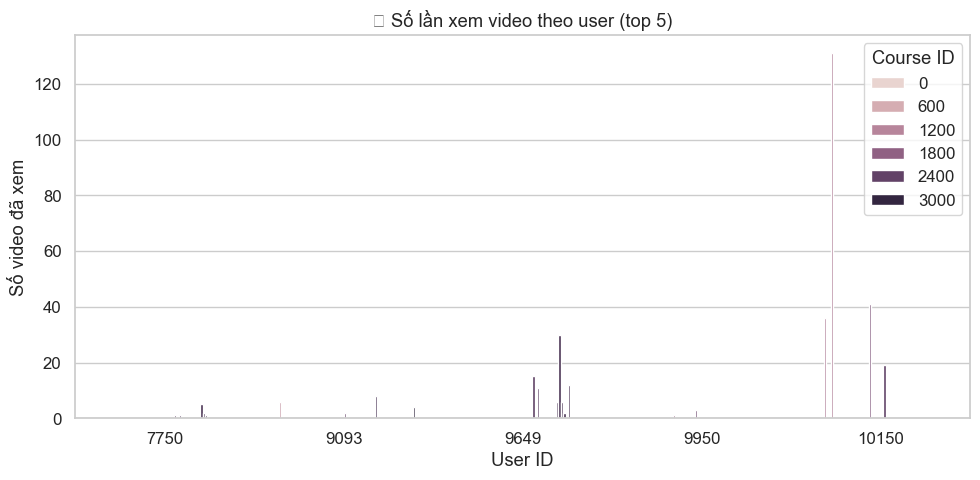

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/2752115879.py:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/2752115879.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


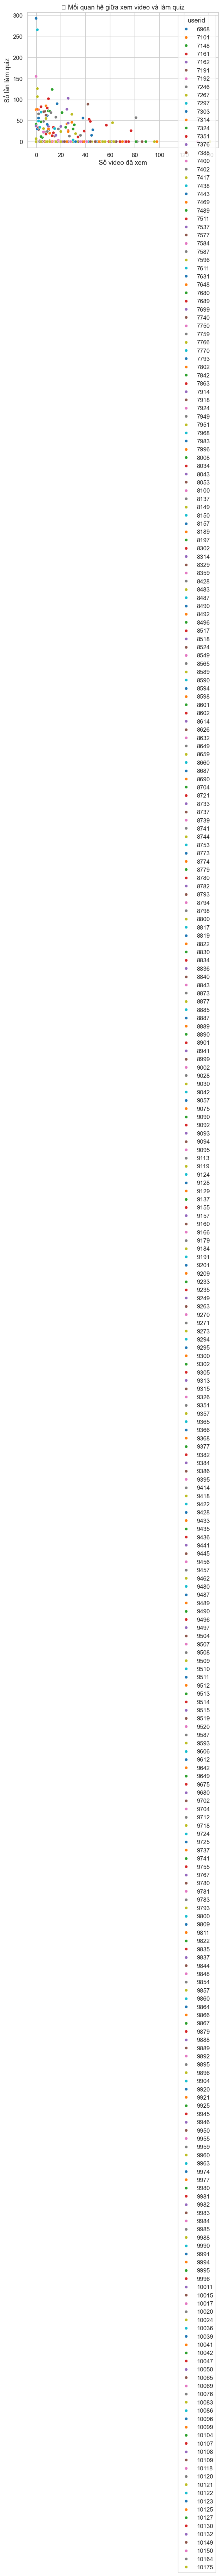

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/2752115879.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.sort_values("num_total_events", ascending=False).head(10),
/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/2752115879.py:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


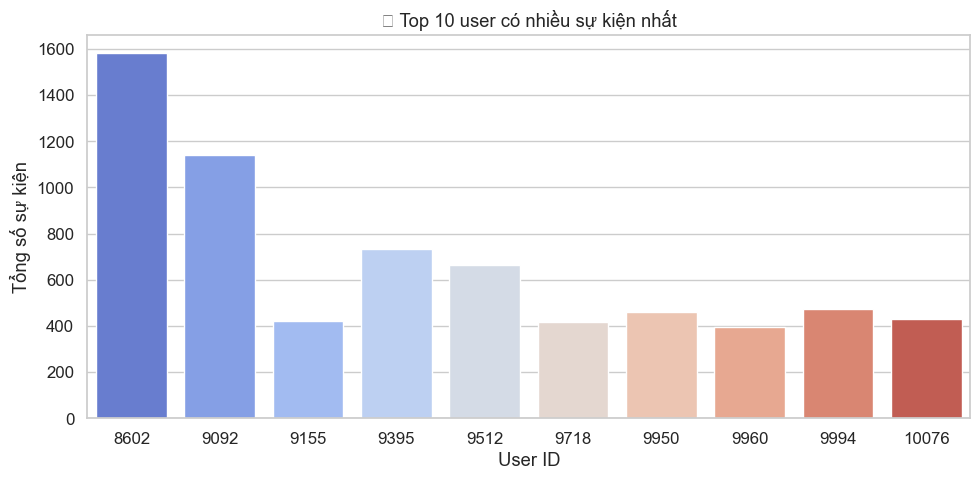

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/2752115879.py:56: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/2752115879.py:56: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


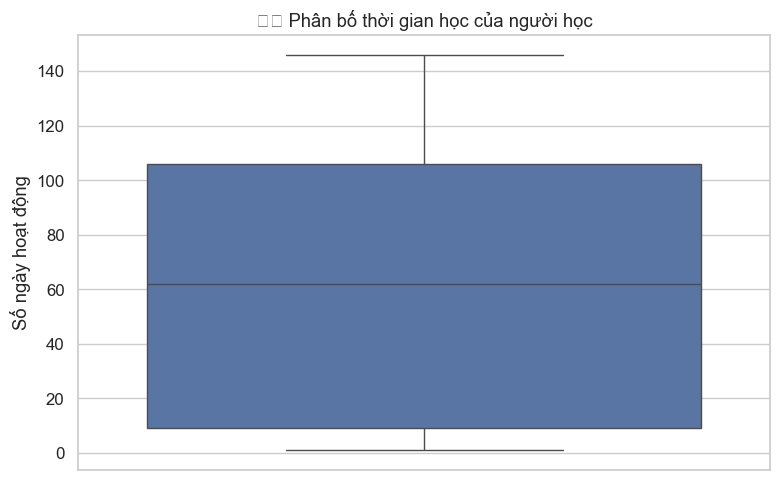

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu
df = pd.read_csv("student_learning_behavior.csv")  # Đổi nếu bạn dùng tên khác

# Thiết lập style đẹp
sns.set(style="whitegrid", font_scale=1.1)

# Biểu đồ 1: Phân bố số lần làm quiz
plt.figure(figsize=(8, 4))
sns.histplot(df['num_quiz_attempts'], bins=20, kde=True)
plt.title("📊 Phân bố số lần làm quiz")
plt.xlabel("Số lần làm quiz")
plt.ylabel("Số học viên")
plt.tight_layout()
plt.show()

# Biểu đồ 2: So sánh video views theo user
plt.figure(figsize=(10, 5))
top_users = df['userid'].value_counts().index[:5]  # 5 user hoạt động nhiều nhất
sns.barplot(data=df[df['userid'].isin(top_users)],
            x="userid", y="num_video_views", hue="courseid")
plt.title("🎥 Số lần xem video theo user (top 5)")
plt.xlabel("User ID")
plt.ylabel("Số video đã xem")
plt.legend(title="Course ID")
plt.tight_layout()
plt.show()

# Biểu đồ 3: Scatter giữa video_views và quiz_attempts
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="num_video_views", y="num_quiz_attempts", hue="userid", palette="tab10")
plt.title("📈 Mối quan hệ giữa xem video và làm quiz")
plt.xlabel("Số video đã xem")
plt.ylabel("Số lần làm quiz")
plt.tight_layout()
plt.show()

# Biểu đồ 4: Tổng số sự kiện theo user
plt.figure(figsize=(10, 5))
sns.barplot(data=df.sort_values("num_total_events", ascending=False).head(10),
            x="userid", y="num_total_events", palette="coolwarm")
plt.title("📊 Top 10 user có nhiều sự kiện nhất")
plt.xlabel("User ID")
plt.ylabel("Tổng số sự kiện")
plt.tight_layout()
plt.show()

# Biểu đồ 5: Boxplot thời gian hoạt động
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, y="duration_days")
plt.title("⏱️ Phân bố thời gian học của người học")
plt.ylabel("Số ngày hoạt động")
plt.tight_layout()
plt.show()

### Phân tích hành vi của 1 user

📍 Phân tích hành vi của userid = 8602
🧾 Số lượng khóa học tham gia: 9
📊 Tổng số dòng log: 9

📌 Các khóa học đã tham gia:
     courseid  num_video_views  num_quiz_attempts  num_assignments_submitted  \
552         0                0                  0                          0   
553         1                0                  0                          0   
554      2492               48                  0                         14   
555      2778                0                  0                          0   
556      2905                8                  0                          4   
557      2906                0                  0                          0   
558      2907                0                  0                          0   
559      2919               57                 39                          1   
560      2920               16                  0                          0   

     num_grade_views  duration_days  
552                0            145  
55

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/4034897452.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_user_behavior, x="courseid", y="num_total_events", palette="Blues_d")
/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/4034897452.py:28: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


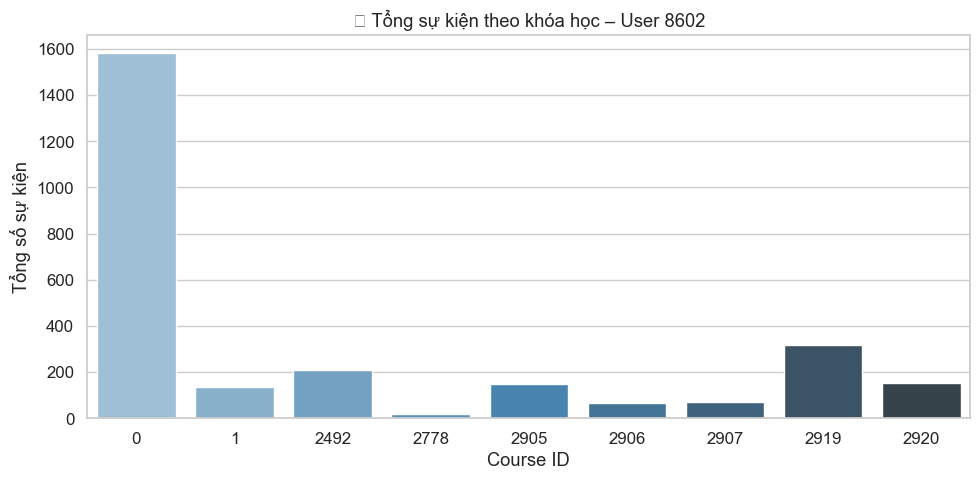

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/4034897452.py:37: UserWarning: Glyph 127909 (\N{MOVIE CAMERA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/4034897452.py:37: UserWarning: Glyph 128209 (\N{BOOKMARK TABS}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127909 (\N{MOVIE CAMERA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128209 (\N{BOOKMARK TABS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


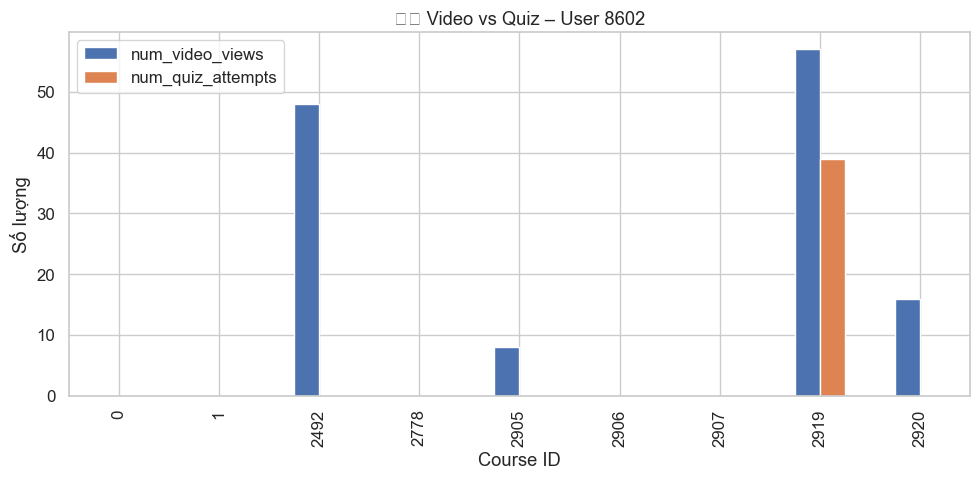

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/4034897452.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_user_behavior, x="courseid", y="duration_days", palette="Purples")
/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/4034897452.py:46: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_48365/4034897452.py:46: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nguyenhuuloc/Documents/MyComputer/Demo_KLTN/.venv/lib

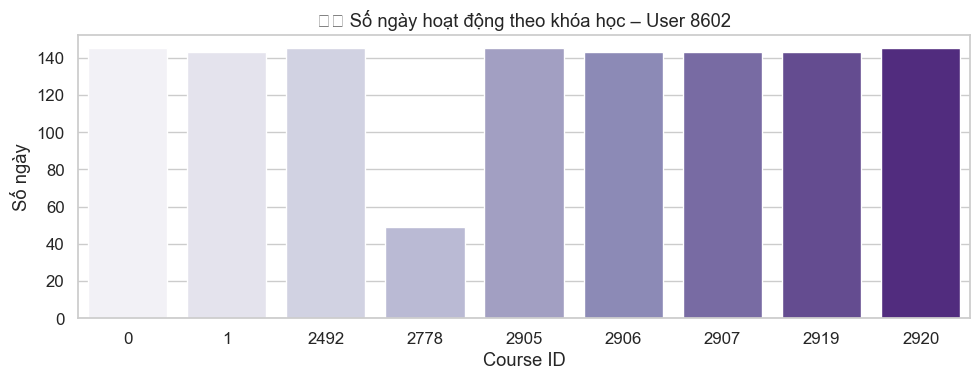

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
df = pd.read_csv("student_learning_behavior.csv")

# Lọc dữ liệu của user cần phân tích
user_id = 8602
# 2. Lọc dữ liệu đã tổng hợp hành vi
df_user_behavior = df_behavior[df_behavior["userid"] == user_id]


# Xem thông tin tổng quan
print(f"📍 Phân tích hành vi của userid = {user_id}")
print(f"🧾 Số lượng khóa học tham gia: {df_user_behavior['courseid'].nunique()}")
print(f"📊 Tổng số dòng log: {len(df_user_behavior)}")
print("\n📌 Các khóa học đã tham gia:")
print(df_user_behavior[["courseid", "num_video_views", "num_quiz_attempts",
               "num_assignments_submitted", "num_grade_views", "duration_days"]])

# Biểu đồ: Hoạt động trong từng course
plt.figure(figsize=(10, 5))
sns.barplot(data=df_user_behavior, x="courseid", y="num_total_events", palette="Blues_d")
plt.title(f"📘 Tổng sự kiện theo khóa học – User {user_id}")
plt.xlabel("Course ID")
plt.ylabel("Tổng số sự kiện")
plt.tight_layout()
plt.show()

# Biểu đồ: Số lần xem video và làm quiz
df_user_plot = df_user_behavior.set_index("courseid")[["num_video_views", "num_quiz_attempts"]]
df_user_plot.plot(kind="bar", figsize=(10, 5))
plt.title(f"🎥📑 Video vs Quiz – User {user_id}")
plt.ylabel("Số lượng")
plt.xlabel("Course ID")
plt.tight_layout()
plt.show()

# Biểu đồ: Thời gian hoạt động theo khóa
plt.figure(figsize=(10, 4))
sns.barplot(data=df_user_behavior, x="courseid", y="duration_days", palette="Purples")
plt.title(f"⏱️ Số ngày hoạt động theo khóa học – User {user_id}")
plt.xlabel("Course ID")
plt.ylabel("Số ngày")
plt.tight_layout()
plt.show()